In [17]:
import scipy.io
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

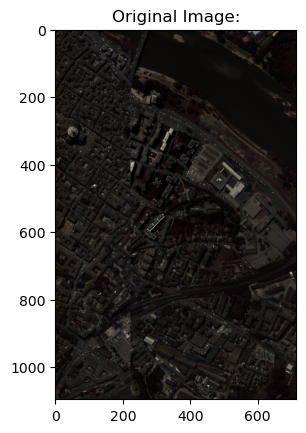

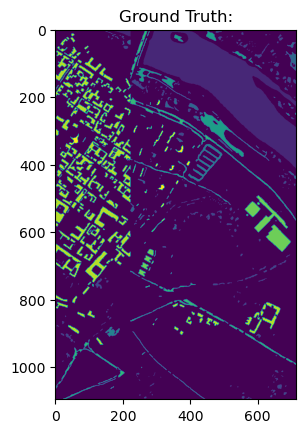

In [18]:
#Loading and Normalising the Data

data = scipy.io.loadmat('Pavia')['pavia']
gt = scipy.io.loadmat('Pavia_gt')['pavia_gt'] 

rgb_bands = [29, 19, 9]
rgb_image = data[:, :, rgb_bands]

rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.title("Original Image:")
plt.imshow((rgb_image * 255).astype(np.uint8))  # Convert to 8-bit for display
plt.show()

plt.title("Ground Truth:")
plt.imshow(gt, cmap='viridis')
plt.show()

In [19]:
print("Pavia shape:", data.shape)
print("Pavia_gt shape:", gt.shape)


Pavia shape: (1096, 715, 102)
Pavia_gt shape: (1096, 715)


In [20]:
print("Min value:", np.min(data))
print("Max value:", np.max(data))
print("Data type:", data.dtype)

Min value: 0
Max value: 8000
Data type: uint16


In [21]:
unique_labels = np.unique(gt)
print("Unique labels in ground truth:", unique_labels)

Unique labels in ground truth: [0 1 2 3 4 5 6 7 8 9]


In [22]:
# Reshape the data
data_reshaped = rgb_image.reshape((-1, len(rgb_bands)))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_reshaped, gt.ravel(), test_size=0.2, random_state=42)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Reshape the data into 3D patches
patch_size = 5
data_patches = []

for i in range(data.shape[0] - patch_size + 1):
    for j in range(data.shape[1] - patch_size + 1):
        patch = rgb_image[i:i+patch_size, j:j+patch_size, :]
        data_patches.append(patch)

data_patches = np.array(data_patches)
data_patches = data_patches.reshape((-1, patch_size, patch_size, len(rgb_bands)))

# Reshape the ground truth patches
gt_patches = []

for i in range(gt.shape[0] - patch_size + 1):
    for j in range(gt.shape[1] - patch_size + 1):
        patch = gt[i:i+patch_size, j:j+patch_size]
        gt_patches.append(np.unique(patch)[0])  # Use the most common label in the patch

gt_patches = np.array(gt_patches)

print("Shape of data patches:", data_patches.shape)
#print("Shape of ground truth patches:", gt_patches.shape)


# Ensure the number of samples is the same for features and labels
min_samples = min(data_patches.shape[0], gt_patches.shape[0])
data_patches = data_patches[:min_samples, :]
gt_patches = gt_patches[:min_samples]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_patches, gt_patches, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(patch_size, patch_size, len(rgb_bands))))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))  # Adjust output size based on your number of classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))
model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)

Shape of data patches: (776412, 5, 5, 3)
Epoch 1/2
15529/15529 [==============================] - 59s 4ms/step - loss: 0.2487 - accuracy: 0.9293 - val_loss: 0.1720 - val_accuracy: 0.9512
Epoch 2/2
15529/15529 [==============================] - 58s 4ms/step - loss: 0.1651 - accuracy: 0.9520 - val_loss: 0.1623 - val_accuracy: 0.9521


4853/4853 [==============================] - 11s 2ms/step


C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.96      0.98      0.97    139658
           2       0.83      0.88      0.85     11992
           3       0.00      0.00      0.00       122
           4       0.00      0.00      0.00       147
           5       0.00      0.00      0.00        51
           6       0.00      0.00      0.00       557
           7       0.00      0.00      0.00        82
           8       0.00      0.00      0.00       868
           9       0.00      0.00      0.00      1761
          10       0.00      0.00      0.00        45

    accuracy                           0.95    155283
   macro avg       0.18      0.19      0.18    155283
weighted avg       0.93      0.95      0.94    155283



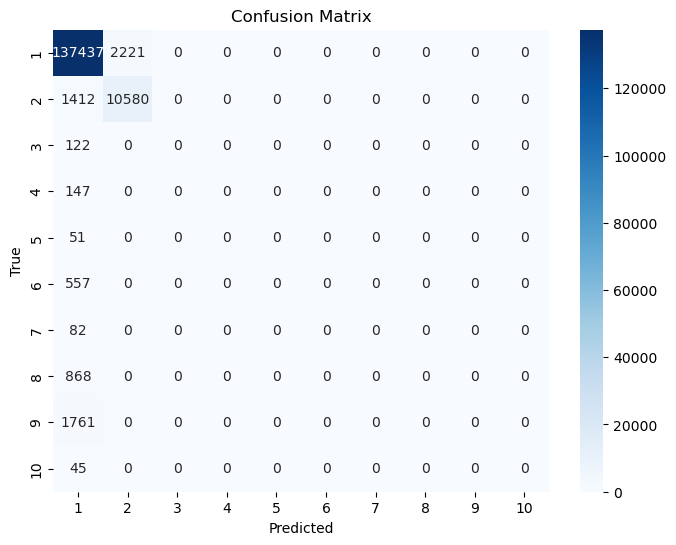

In [25]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

target_names = [str(i) for i in range(1, len(np.unique(gt_patches)) + 1)]  # Assuming class labels start from 1
print(classification_report(y_test, y_pred_classes, target_names=target_names))

conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()